In [1]:
from notebook_tools import *
from scipy import optimize
%matplotlib inline

# pp-SRC analysis

In [2]:
columns = ['Q2' , 'Xb' , 'p/q' ,'theta (pq)' , 'Mmiss' ,'Pmiss3Mag','pcmX','pcmY','pcmZ' , 'rooWeight' ,
          'theta (rec-q)' , 'OpeningAngle']
targets = ['C12','Al27','Fe56','Pb208']
colors = ['red','blue','purple','black']
target_names = ['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'] 
ana = dict()
for target in targets:
    ana[target] = read_root( "/Users/erezcohen/Desktop/DataMining/AnaFiles/Ana_ppSRCcut_DATA_%s.root"%target , key='anaTree' , columns=columns  )


In [3]:
def gauss_func(x, C , mean, sigma):
    return C/np.sqrt(2*np.pi*sigma)*np.exp( -np.square(x-mean)/(2*np.square(sigma)) )

In [4]:
# runs 10,000 - 72,500
AccCorr = pd.DataFrame({'A':[12 , 27 , 56 , 208],
                        's_t_AccCorr':[160,157,182,175],
                        's_t_AccCorrErr':[9,18,9,15]},index = ['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'])
# c.m. resolution correction
AccCorr['s_t_final'] = np.sqrt( np.square(AccCorr['s_t_AccCorr']) - np.square(20))
AccCorr['s_t_final_Err'] = np.sqrt( np.square(AccCorr['s_t_AccCorrErr']) + np.square(5))

AccCorr

,A,s_t_AccCorr,s_t_AccCorrErr,s_t_final,s_t_final_Err
$^{12}$C,12,160,9,158.745079,10.295630
$^{27}$Al,27,157,18,155.720904,18.681542
$^{56}$Fe,56,182,9,180.897761,10.295630
$^{208}$Pb,208,175,15,173.853387,15.811388


C: 130.0
standard deviation: 165, fit sigma: 165 +/- 5 MeV/c
np.max(y_gaus): 127.767475733
158.745078664 10.295630141
C: 47.0
standard deviation: 171, fit sigma: 171 +/- 9 MeV/c
np.max(y_gaus): 45.365382287
155.720904184 18.6815416923
C: 128.0
standard deviation: 174, fit sigma: 174 +/- 5 MeV/c
np.max(y_gaus): 122.43929896
180.89776118 10.295630141
C: 30.0
standard deviation: 199, fit sigma: 199 +/- 12 MeV/c
np.max(y_gaus): 26.8473406698
173.853386507 15.8113883008


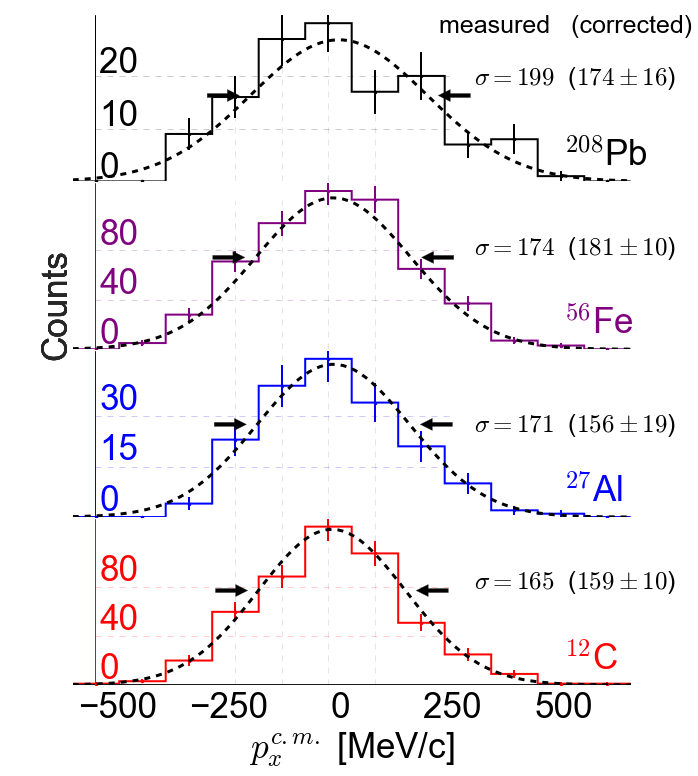

In [14]:
# make p(c.m.) in a nice style using also keyone
xmin , xmax , nbins = -600,650, 13
fontsize = 35
gauscolor = 'black'

bins=np.linspace(xmin , xmax , nbins )
x_gaus = np.linspace(np.min(bins),np.max(bins),100)

figsize=(10,12)
fig = plt.figure(figsize=figsize)

y_ticks_targets = [[0, 40, 80],[0, 15, 30],[0, 40, 80],[0, 10, 20]]

for i,target,target_name,color,y_ticks in zip(range(4),targets,target_names,colors,y_ticks_targets):
    x = 1000*ana[target].pcmX #np.sqrt(0.5)*(ana[target].pcmX + ana[target].pcmY)
    x_label = '$p^{c.m.}_{x}$ [MeV/c]' if target is 'C12' else '' # = (p^{c.m.}_{x}+p^{c.m.}_{y})/2


    mean = np.average(x)
    sigma = np.sqrt(np.average(np.square(x-mean)))
        
    ax = fig.add_subplot(4,1,4-i)
    h,bins,_=plt.hist(x,bins=bins,histtype='step',linewidth=2,color=color);
    mid = bins[0:-1] + 0.5*(bins[1]-bins[0])
    plt.errorbar( mid , y=h , yerr=np.sqrt(h) , fmt='.',linewidth=2 , color=color);
    C = np.max(h)
    print 'C:',C
    
    # Fit the set
    fana = TAnalysisEG2( "/Users/erezcohen/Desktop/DataMining/AnaFiles" , "Ana_ppSRCcut_DATA_%s"%target )
    roofits = fana.RooFitCM( 0.2 , 1.1 , False , False , 2 )
    df = pd.DataFrame({'mean_x':roofits[0],'mean_xErr':roofits[1],'sigma_x':roofits[2],'sigma_xErr':roofits[3]                                      
                   ,'mean_y':roofits[4],'mean_yErr':roofits[5],'sigma_y':roofits[6],'sigma_yErr':roofits[7]}                                       
                   , index=[i])
    roofit_mean = 1000*float(df.mean_x)
    roofit_sigma , roofit_sigmaErr = 1000*float(df.sigma_x),1000*float(df.sigma_xErr)
    print 'standard deviation: %.0f, fit sigma: %.0f +/- %.0f MeV/c'%(sigma,roofit_sigma , roofit_sigmaErr)

    y_sigma = C/np.sqrt(2*np.pi*roofit_sigma/1000.)*np.exp(-0.5)   
#     y_gaus = C/np.sqrt(2*np.pi*sigma)*np.exp( -np.square(x_gaus-mean)/(2*np.square(roofit_sigma)) )
    y_gaus = C/np.sqrt(2*np.pi*roofit_sigma/1000.)*np.exp( -np.square(x_gaus-roofit_mean)/(2*np.square(roofit_sigma)) )
    print 'np.max(y_gaus):',np.max(y_gaus)
    plt.plot(x_gaus,y_gaus,'--',color=gauscolor,linewidth=3);

    


    ymax = 1.05*np.max([np.max(h),C/np.sqrt(2*np.pi*roofit_sigma)])
    ax.set_ylim(0,ymax)

    if i==0:
        plt.axhspan(xmin=-1,xmax=1,ymin=0,ymax=0,linewidth=3)

    else:
        ax.xaxis.set_major_formatter( NullFormatter() )
        ax.set_axis_off()

    plt.text(xmax-150 , 0.1*np.max(h) , target_name , color=color , fontsize=35)
    ax.set_xlim(xmin , xmax)
    plt.xticks(np.linspace(xmin + 200 , xmax - 200 , 5))
    set_axes(ax,x_label=x_label,fontsize=35)
    plt.subplots_adjust(hspace=0.01)


    # add grid lines
    for j,tick in zip(range(len(mid)),mid):
        if j < 3 or j > nbins-7:
            continue 
        if i==2  :
            y_max = 0.9*ymax # h[j]
        elif i==3:
            y_max = h[j]
        else:
            y_max = ymax
        line = plt.Line2D([tick,tick],[0,y_max],linewidth=1,linestyle='--',color='black',alpha=0.1)
        ax.add_artist(line)


    # add x-axis to the bottom subplot (12C)
    if i==0:
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('none')
        ax.tick_params(labeltop='off', labelleft='off')
        customaxis(ax,c_left='none',c_bottom='none')


    # add vertical axes
    x_yaxis = -550 # xmin + 167.5*(xmax-xmin)*(1-0.2*i*0)
    line = plt.Line2D([x_yaxis,x_yaxis],[0,ymax],linewidth=1,linestyle='-',color=color)
    ax.add_artist(line)
    
    
    for y_tick in y_ticks: 
        ax.text(x_yaxis+10,y_tick+0.04*y_max,'%d'%y_tick,fontsize=fontsize,color=color)
        line = plt.Line2D([x_yaxis,-x_yaxis-300],[y_tick,y_tick],linewidth=1,linestyle='--',color=color,alpha=0.2)
        ax.add_artist(line)

    # add sigma lines and text
    s_t_final , s_t_final_Err = float(AccCorr[AccCorr.index==target_name]['s_t_final']),float(AccCorr[AccCorr.index==target_name]['s_t_final_Err'])
    print s_t_final , s_t_final_Err
    
    x_text = xmax - 350 # mean+sigma+110
    y_text = y_sigma+2 if i!=1 else y_sigma-2
    
    if target is 'Pb208':
        plt.text( x_text-80 , y_text+10,'measured   (corrected)',color=gauscolor,fontsize=25)

    plt.text(x_text, y_text,'$\\sigma=%.0f $  ($%.0f \pm %.0f $)'%(roofit_sigma , s_t_final , s_t_final_Err),color=gauscolor,fontsize=25)
    ax.annotate('', xy=(mean+sigma+20, y_sigma), xytext=(mean+sigma+100, y_sigma),arrowprops=dict(facecolor=gauscolor, shrink=0.05))
    ax.annotate('', xy=(mean-sigma-20, y_sigma), xytext=(mean-sigma-100, y_sigma),arrowprops=dict(facecolor=gauscolor, shrink=0.05))

    plt.xticks([-500, -250, 0, 250, 500])
    plt.figtext(0.08,0.6,"Counts",fontdict={'fontsize':fontsize},rotation=90)
#     plt.tight_layout()
    plt.savefig('/Users/erezcohen/Desktop/DataMining/2NSRC/ppSRCcmPaper/Figures/pcm_alltargets.pdf')
        

standard deviation: 165, fit sigma: 165 +/- 5 MeV/c
158.745078664 10.295630141
standard deviation: 171, fit sigma: 171 +/- 9 MeV/c
155.720904184 18.6815416923
standard deviation: 174, fit sigma: 174 +/- 5 MeV/c
180.89776118 10.295630141
standard deviation: 199, fit sigma: 199 +/- 12 MeV/c
173.853386507 15.8113883008


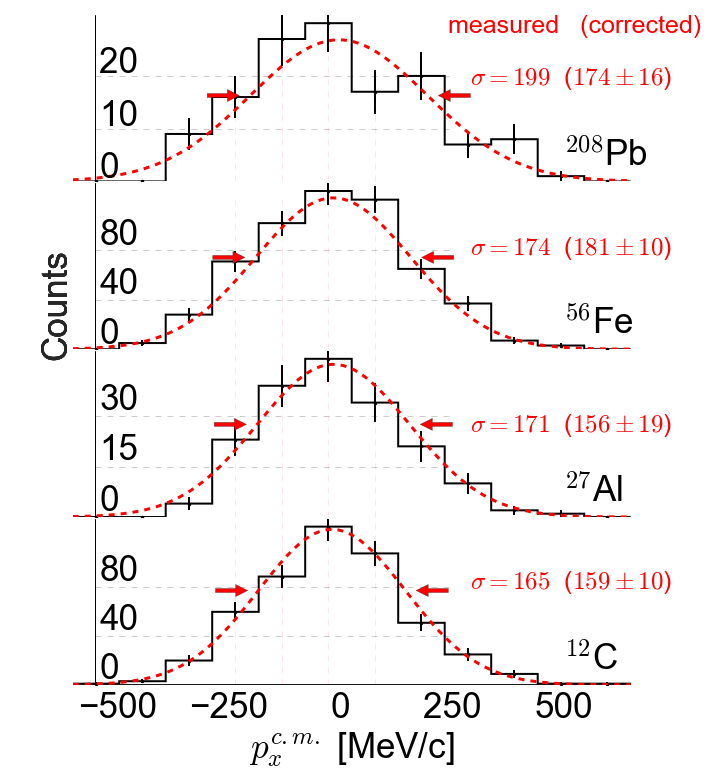

In [16]:
# make p(c.m.) in a nice style using also keyone
xmin , xmax , nbins = -600,650, 13
fontsize = 35
gauscolor = 'red'

bins=np.linspace(xmin , xmax , nbins )
x_gaus = np.linspace(np.min(bins),np.max(bins),100)

figsize=(10,12)
fig = plt.figure(figsize=figsize)

y_ticks_targets = [[0, 40, 80],[0, 15, 30],[0, 40, 80],[0, 10, 20]]

for i,target,target_name,color,y_ticks in zip(range(4),targets,target_names,['black','black','black','black'],y_ticks_targets):
    x = 1000*ana[target].pcmX 
    x_label = '$p^{c.m.}_{x}$ [MeV/c]' if target is 'C12' else '' 

    mean = np.average(x)
    sigma = np.sqrt(np.average(np.square(x-mean)))
        
    ax = fig.add_subplot(4,1,4-i)
    h,bins,_=plt.hist(x,bins=bins,histtype='step',linewidth=2,color=color);
    mid = bins[0:-1] + 0.5*(bins[1]-bins[0])
    plt.errorbar( mid , y=h , yerr=np.sqrt(h) , fmt='.',linewidth=2 , color=color);
    C = np.max(h)

    # Fit the set
    fana = TAnalysisEG2( "/Users/erezcohen/Desktop/DataMining/AnaFiles" , "Ana_ppSRCcut_DATA_%s"%target )
    roofits = fana.RooFitCM( 0.2 , 1.1 , False , False , 2 )
    df = pd.DataFrame({'mean_x':roofits[0],'mean_xErr':roofits[1],'sigma_x':roofits[2],'sigma_xErr':roofits[3]                                      
                   ,'mean_y':roofits[4],'mean_yErr':roofits[5],'sigma_y':roofits[6],'sigma_yErr':roofits[7]}                                       
                   , index=[i])
    roofit_mean = 1000*float(df.mean_x)
    roofit_sigma , roofit_sigmaErr = 1000*float(df.sigma_x),1000*float(df.sigma_xErr)
    print 'standard deviation: %.0f, fit sigma: %.0f +/- %.0f MeV/c'%(sigma,roofit_sigma , roofit_sigmaErr)

    y_sigma = C/np.sqrt(2*np.pi*roofit_sigma/1000.)*np.exp(-0.5)   
    y_gaus = C/np.sqrt(2*np.pi*roofit_sigma/1000.)*np.exp( -np.square(x_gaus-roofit_mean)/(2*np.square(roofit_sigma)) )
    plt.plot(x_gaus,y_gaus,'--',color=gauscolor,linewidth=3);

    ymax = 1.05*np.max([np.max(h),C/np.sqrt(2*np.pi*roofit_sigma)])
    ax.set_ylim(0,ymax)

    if target is 'C12':
        plt.axhspan(xmin=-1,xmax=1,ymin=0,ymax=0,linewidth=3)
    else:
        ax.xaxis.set_major_formatter( NullFormatter() )
        ax.set_axis_off()

    plt.text(xmax-150 , 0.1*np.max(h) , target_name , color=color , fontsize=35)
    ax.set_xlim(xmin , xmax)
    plt.xticks(np.linspace(xmin + 200 , xmax - 200 , 5))
    set_axes(ax,x_label=x_label,fontsize=35)
    plt.subplots_adjust(hspace=0.01)


    # add grid lines
    for j,tick in zip(range(len(mid)),mid):
        if j < 3 or j > nbins-7:
            continue 
        if i==2  :
            y_max = 0.9*ymax # h[j]
        elif i==3:
            y_max = h[j]
        else:
            y_max = ymax
        line = plt.Line2D([tick,tick],[0,y_max],linewidth=1,linestyle='--',color='red',alpha=0.1)
        ax.add_artist(line)

    # add x-axis to the bottom subplot (12C)
    if i==0:
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('none')
        ax.tick_params(labeltop='off', labelleft='off')
        customaxis(ax,c_left='none',c_bottom='none')


    # add vertical axes
    x_yaxis = -550 # xmin + 167.5*(xmax-xmin)*(1-0.2*i*0)
    line = plt.Line2D([x_yaxis,x_yaxis],[0,ymax],linewidth=1,linestyle='-',color=color)
    ax.add_artist(line)
    
    
    for y_tick in y_ticks: 
        ax.text(x_yaxis+10,y_tick+0.04*y_max,'%d'%y_tick,fontsize=fontsize,color=color)
        line = plt.Line2D([x_yaxis,-x_yaxis-300],[y_tick,y_tick],linewidth=1,linestyle='--',color=color,alpha=0.2)
        ax.add_artist(line)

    # add sigma lines and text
    s_t_final , s_t_final_Err = float(AccCorr[AccCorr.index==target_name]['s_t_final']),float(AccCorr[AccCorr.index==target_name]['s_t_final_Err'])
    print s_t_final , s_t_final_Err
    
    x_text = xmax - 360 # mean+sigma+110
    y_text = y_sigma+2 if i!=1 else y_sigma-2
    
    if target is 'Pb208':
        plt.text( x_text-50 , y_text+10,'measured   (corrected)',color=gauscolor,fontsize=25)

    plt.text(x_text, y_text,'$\\sigma=%.0f $  ($%.0f \pm %.0f $)'%(roofit_sigma , s_t_final , s_t_final_Err),color=gauscolor,fontsize=25)
    ax.annotate('', xy=(mean+sigma+20, y_sigma), xytext=(mean+sigma+100, y_sigma),arrowprops=dict(facecolor=gauscolor, shrink=0.05))
    ax.annotate('', xy=(mean-sigma-20, y_sigma), xytext=(mean-sigma-100, y_sigma),arrowprops=dict(facecolor=gauscolor, shrink=0.05))

    plt.xticks([-500, -250, 0, 250, 500])
    plt.figtext(0.08,0.6,"Counts",fontdict={'fontsize':fontsize},rotation=90)
    plt.savefig('/Users/erezcohen/Desktop/DataMining/2NSRC/ppSRCcmPaper/Figures/pcm_alltargets_nocolors.pdf')